In [1]:
import os
import sys
import torch

import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import lightning.pytorch as pl
import seaborn as sns
import numpy as np

from lightning.pytorch import loggers as pl_loggers
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
from torchmetrics import Accuracy
from torchmetrics.classification import MulticlassF1Score
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from Resnet_from_scratch import ResNet18, ResNet34, ResNet50, ResNet101, ResNet152
from lightning.pytorch.loggers import CSVLogger
from PIL import Image
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score



ImportError: cannot import name 'multiclass_f1_score' from 'torchmetrics' (/home/mshaker/miniconda3/envs/res/lib/python3.9/site-packages/torchmetrics/__init__.py)

In [21]:
DATA_DIR = os.path.join(os.curdir, "data","raw", "dataset")

In [22]:
TRAIN_SIZE = 0.8
BATCH_SIZE = 32
LEARNING_RATE = 1.2E-4

In [23]:
class ResNetLightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate, num_classes=11):
        super(ResNetLightningModule, self).__init__()
        self.model = model
        self.learning_rate = learning_rate
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])
        self.criterion = nn.CrossEntropyLoss()
        self.accuracy = Accuracy(task="multiclass", num_classes = num_classes)
        self.f1 = MulticlassF1Score(num_classes=num_classes)


    def forward(self, x):
        # Input is preprocessed input
        # Output is post-processed output

        logits = self.model(x)
        return nn.functional.softmax(logits, dim=-1)
        


    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat.softmax(dim=-1), y)
        self.log('train_loss', loss, prog_bar=True)
        self.log('train_acc', acc, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat.softmax(dim=-1), y)
        self.log('val_loss', loss, prog_bar=True)
        self.log('val_acc', acc, prog_bar=True)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        acc = self.accuracy(y_hat.softmax(dim=-1), y)
        self.log('test_loss', loss)
        self.log('test_acc', acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.learning_rate)
    
        
    

In [24]:
class ImageFolderDataModule(pl.LightningDataModule):
    def __init__(self, data_dir, batch_size=32, train_size=0.8):
        super().__init__()
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.train_size = train_size
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
            ),
        ])

    def setup(self, stage=None):
        dataset = datasets.ImageFolder(self.data_dir, transform=self.transform)
        train_size = int(self.train_size * len(dataset))
        val_size = int(0.1 * len(dataset))
        test_size = len(dataset) - train_size - val_size
        self.train_dataset, self.val_dataset, self.test_dataset = random_split(dataset, [train_size, val_size, test_size])

    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, shuffle=True)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)

    def test_dataloader(self):
        return DataLoader(self.test_dataset, batch_size=self.batch_size, shuffle=False)
    
    


In [25]:
def plot_loss_curves(logger):
    metrics_path = os.path.join(logger.save_dir, logger.name, f"version_{logger.version}", "metrics.csv")
    
    if not os.path.exists(metrics_path):
        raise FileNotFoundError(f"Metrics file not found at: {metrics_path}")

    metrics = pd.read_csv(metrics_path)

    plt.figure(figsize=(10, 5))
    train_loss = metrics.dropna(subset=['train_loss'])
    val_loss = metrics.dropna(subset=['val_loss'])
    
    plt.plot(train_loss['epoch'], train_loss['train_loss'], label='Training Loss')
    plt.plot(val_loss['epoch'], val_loss['val_loss'], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Training vs Validation Loss')
    plt.show()

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | ResNet             | 11.2 M | train
1 | criterion | CrossEntropyLoss   | 0      | train
2 | accuracy  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.748    Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/mshaker/miniconda3/envs/res/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.
/home/mshaker/miniconda3/envs/res/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/mshaker/miniconda3/envs/res/lib/python3.9/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=31` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.631732165813446
        test_loss           1.0721036195755005
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


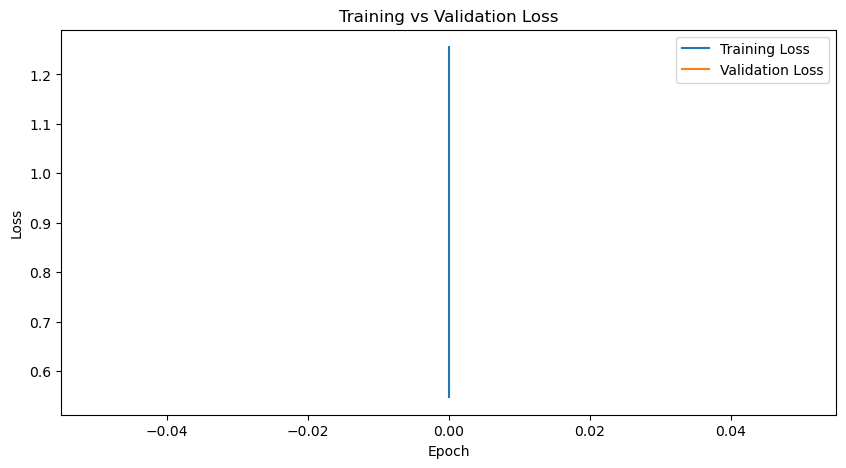

In [26]:
model = ResNet18(num_classes = 11, channels = 3)
pl_model = ResNetLightningModule(model)

data_dir = os.path.join(os.curdir, "data", "raw", "dataset")
data_module = ImageFolderDataModule(data_dir)

csv_logger = pl_loggers.CSVLogger('logs/', name='csv_logs')

early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=0.05, patience=3, mode="min")

trainer = pl.Trainer(callbacks=[early_stop_callback] ,max_epochs = 20 , devices = 1, accelerator='gpu', logger = csv_logger)
trainer.fit(pl_model, data_module)
trainer.test(pl_model, data_module)

plot_loss_curves(csv_logger)
    



In [27]:
# Ensure the data_module instance is used for calling test_dataloader
test_dataloader = data_module.test_dataloader()

# Set the model to evaluation mode
test_model = pl_model.model
test_model.eval()


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Sequential()
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): Bat

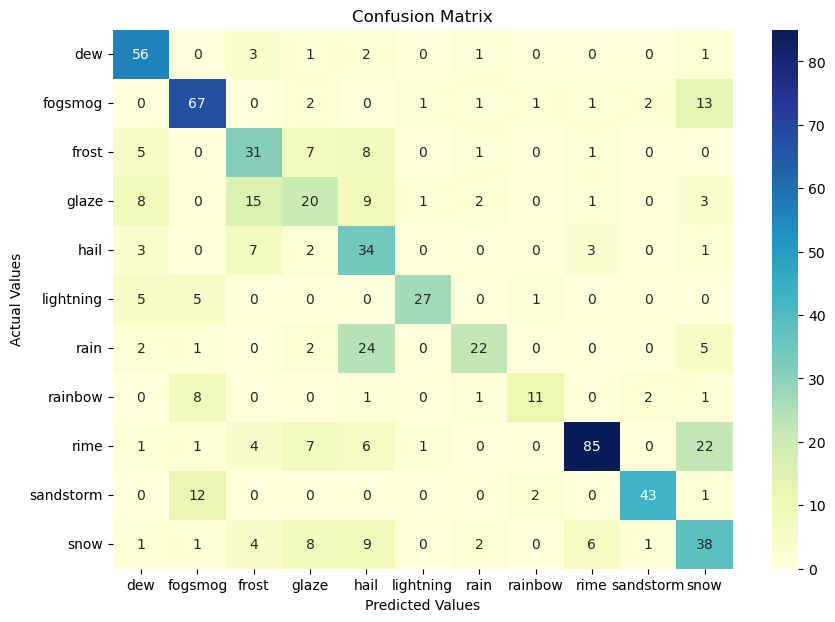

Accuracy: 0.9330
Precision per class: [0.69135802 0.70526316 0.484375   0.40816327 0.3655914  0.9
 0.73333333 0.73333333 0.87628866 0.89583333 0.44705882]
Recall per class: [0.875      0.76136364 0.58490566 0.33898305 0.68       0.71052632
 0.39285714 0.45833333 0.66929134 0.74137931 0.54285714]
F1 Score per class: [0.77241379 0.73224044 0.52991453 0.37037037 0.47552448 0.79411765
 0.51162791 0.56410256 0.75892857 0.81132075 0.49032258]
Macro F1 Score: 0.6192
Micro F1 Score: 0.6317


In [29]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    
    TP = np.diag(cm)
    FP = cm.sum(axis=0) - TP
    FN = cm.sum(axis=1) - TP
    TN = cm.sum() - (FP + FN + TP)

    return cm, all_labels, all_preds, TP, FP, FN, TN

def calculate_macro_micro_f1(all_labels, all_preds):
    macro_f1 = f1_score(all_labels, all_preds, average='macro')
    micro_f1 = f1_score(all_labels, all_preds, average='micro')
    return macro_f1, micro_f1

conf_matrix, all_labels, all_preds, TP, FP, FN, TN = compute_metrics(test_model, test_dataloader)

cm_df = pd.DataFrame(conf_matrix, index =[i for i in ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']],
                     columns=[i for i in ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title('Confusion Matrix')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

accuracy = (TP.sum() + TN.sum()) / (TP.sum() + TN.sum() + FP.sum() + FN.sum())
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1_score_per_class = 2 * (precision * recall) / (precision + recall)

macro_f1, micro_f1 = calculate_macro_micro_f1(all_labels, all_preds)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision per class: {precision}")
print(f"Recall per class: {recall}")
print(f"F1 Score per class: {f1_score_per_class}")
print(f"Macro F1 Score: {macro_f1:.4f}")
print(f"Micro F1 Score: {micro_f1:.4f}")

model with working cm, and uses load best checkpoint for fututre use:
https://github.com/rasbt/deeplearning-models/blob/master/pytorch-lightning_ipynb/cnn/cnn-vgg16.ipynb